

https://www.kaggle.com/datasets/gingerbadger/redditmods-moderators-of-top-25k-subreddits/data

In [3]:
!pip install powerlaw

import powerlaw
import networkx as nx

import kagglehub

import matplotlib.pyplot as plt
from google.colab import drive
%matplotlib inline

In [4]:


# Download latest version
path = kagglehub.dataset_download("gingerbadger/redditmods-moderators-of-top-25k-subreddits")

print("Path to dataset files:", path)
reddit_graph=nx.read_gexf(path+"/graph.gexf")


100%|██████████| 14.4M/14.4M [00:00<00:00, 83.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gingerbadger/redditmods-moderators-of-top-25k-subreddits/versions/1


In [5]:

print(reddit_graph)
kcore = 2 #lets try 2: reduces size by ~10x ish. 4 cuts things down by a factor of ~100x
G=nx.k_core(reddit_graph,kcore)
print(G)

Graph with 118929 nodes and 125812 edges
Graph with 18624 nodes and 36200 edges


**NOTES**
- the fundamental k-core is very small, using a 4-core gives us a 100x size reduction. using a 2-core gives us roughly 10x size reduction.
-it should be expected that moderators have a (roughly) non-power distribution, as the labor requirements arent going to scale. subreddits, otoh, might have some power distribution (bigger subreddits-might be useful data)

In [ ]:

moderator_nodes_fullgraph = {n for n,d in reddit_graph.nodes(data=True) if d.get('bipartite')==0}
subreddit_nodes_fullgraph = set(reddit_graph) - moderator_nodes_fullgraph

moderator_degrees_1count =len([n for n in moderator_nodes_fullgraph if reddit_graph.degree(n) == 1])
print("number of moderators with one subreddit:", moderator_degrees_1count)

subreddit_degrees_1count =len([n for n in subreddit_nodes_fullgraph if reddit_graph.degree(n) == 1])
print("number of subreddits with one moderator:",subreddit_degrees_1count)

number of moderators with one subreddit: 79435
number of subreddits with one moderator: 3990


In [ ]:
#NONBIPARTITE GRAPH: computationally expensive, and doesnt show much
'''
# Draw with a layout
pos = nx.spring_layout(G)      # or nx.kamada_kawai_layout(G)
color_map={1:(1,0,0,0.2),0:(0,0,0,0.5)}
node_color=[color_map[attr["bipartite"]] for (id,attr) in G.nodes(data=True)]
nx.draw(G, pos,
        node_size=20,
        node_color=node_color,
        edge_color=(0, 0, 1, 0.2),
        with_labels=False)

plt.show()
'''

'\n# Draw with a layout\npos = nx.spring_layout(G)      # or nx.kamada_kawai_layout(G)\ncolor_map={1:(1,0,0,0.2),0:(0,0,0,0.5)}\nnode_color=[color_map[attr["bipartite"]] for (id,attr) in G.nodes(data=True)]\nnx.draw(G, pos,\n        node_size=20,\n        node_color=node_color,\n        edge_color=(0, 0, 1, 0.2),\n        with_labels=False)\n\nplt.show()\n'

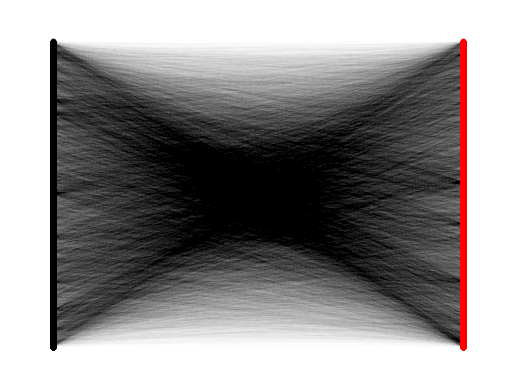

In [ ]:

moderator_nodes = {n for n,d in G.nodes(data=True) if d.get('bipartite')==0}
subreddit_nodes = set(G) - moderator_nodes

pos = nx.bipartite_layout(G,moderator_nodes)

nx.draw_networkx_nodes(G, pos, nodelist=subreddit_nodes, node_color="red", node_size=10)
nx.draw_networkx_nodes(G, pos, nodelist=moderator_nodes, node_color="black", node_size=10)
nx.draw_networkx_edges(G, pos, edge_color=(0,0,0,0.005))
plt.axis('off')
plt.show()



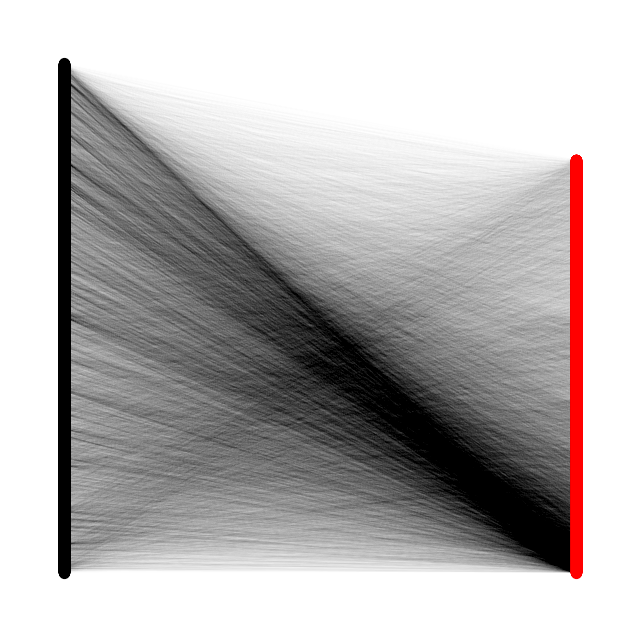

In [ ]:

sorted_subreddits= sorted(subreddit_nodes, key=lambda n: G.degree(n), reverse=True)

# Now build positions manually instead of using nx.bipartite_layout directly
pos = {}

# Give top nodes x=0, spread along y by index
for i, n in enumerate(moderator_nodes):
    pos[n] = (0, i)

# Give bottom nodes x=1, spread along y by index in sorted order
for i, n in enumerate(sorted_subreddits):
    pos[n] = (1, i)

# Draw
plt.figure(figsize=(8,8))
nx.draw_networkx_nodes(G, pos, nodelist=moderator_nodes, node_color='black', node_size=50)
nx.draw_networkx_nodes(G, pos, nodelist=sorted_subreddits, node_color='red', node_size=50)
nx.draw_networkx_edges(G, pos, edge_color=(0,0,0,0.005))
plt.axis('off')
plt.show()


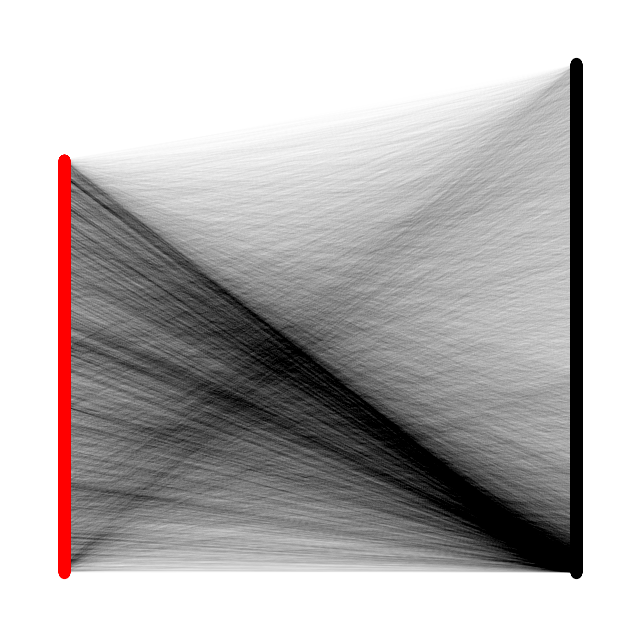

In [ ]:


# Sort bottom nodes by degree (descending)
sorted_moderators = sorted(moderator_nodes, key=lambda n: G.degree(n), reverse=True)

# Now build positions manually instead of using nx.bipartite_layout directly
pos = {}
# Give top nodes x=0, spread along y by index
for i, n in enumerate(subreddit_nodes):
    pos[n] = (0, i)

# Give bottom nodes x=1, spread along y by index in sorted order
for i, n in enumerate(sorted_moderators):
    pos[n] = (1, i)

# Draw
plt.figure(figsize=(8,8))
nx.draw_networkx_nodes(G, pos, nodelist=sorted_subreddits, node_color='red', node_size=50)
nx.draw_networkx_nodes(G, pos, nodelist=sorted_moderators, node_color='black', node_size=50)
nx.draw_networkx_edges(G, pos, edge_color=(0,0,0,0.005))
plt.axis('off')
plt.show()


In [ ]:

moderator_degrees = [ G.degree(n) for n in sorted_moderators]
subreddit_degrees = [ G.degree(n) for n in sorted_subreddits]

powerlaw_moderators=powerlaw.Fit(moderator_degrees)
print("Moderators\n")
print("KS/D fit val:",powerlaw_moderators.power_law.D)
print("alpha:",powerlaw_moderators.power_law.alpha)
print("sigma:",powerlaw_moderators.power_law.sigma)
print("xmin:",powerlaw_moderators.power_law.xmin)
R, p = powerlaw_moderators.distribution_compare('power_law', 'exponential')
print("Log-likelihood ratio R (power_law vs exponential) =", R)
print("p-value for comparison =", p)


powerlaw_subreddits=powerlaw.Fit(subreddit_degrees)
print("Subreddits\n")
print("KS/D fit val:",powerlaw_subreddits.power_law.D)
print("alpha:",powerlaw_subreddits.power_law.alpha)
print("sigma:",powerlaw_subreddits.power_law.sigma)
print("xmin:",powerlaw_subreddits.power_law.xmin)

R, p = powerlaw_moderators.distribution_compare('power_law', 'exponential')
print("Log-likelihood ratio R (power_law vs exponential) =", R)
print("p-value for comparison =", p)


Calculating best minimal value for power law fit
Moderators

KS/D fit val: 0.030249629429987768
alpha: 2.755131150171861
sigma: 0.08273767587721785
xmin: 9.0
Log-likelihood ratio R (power_law vs exponential) = 115.50071079304293
p-value for comparison = 1.711718352960464e-10
Calculating best minimal value for power law fit
Subreddits

KS/D fit val: 0.03650720992077067
alpha: 4.41787020481633
sigma: 0.26137106710408853
xmin: 16.0
Log-likelihood ratio R (power_law vs exponential) = 115.50071079304293
p-value for comparison = 1.711718352960464e-10


In [ ]:
#unfiltered numbers

moderator_nodes_fullgraph = {n for n,d in reddit_graph.nodes(data=True) if d.get('bipartite')==0}
subreddit_nodes_fullgraph=set(reddit_graph)-moderator_nodes_fullgraph
moderator_degrees_fullgraph = [ reddit_graph.degree(n) for n in moderator_nodes_fullgraph]
subreddit_degrees_fullgraph = [ reddit_graph.degree(n) for n in subreddit_nodes_fullgraph]

powerlaw_moderators_fullgraph=powerlaw.Fit(moderator_degrees_fullgraph)
print("Moderators (full graph) \n")
print("KS/D fit val:",powerlaw_moderators_fullgraph.power_law.D)
print("alpha:",powerlaw_moderators_fullgraph.power_law.alpha)
print("sigma:",powerlaw_moderators_fullgraph.power_law.sigma)
print("xmin:",powerlaw_moderators_fullgraph.power_law.xmin)

R, p = powerlaw_moderators_fullgraph.distribution_compare('power_law', 'exponential')
print("Log-likelihood ratio R (power_law vs exponential) =", R)
print("p-value for comparison =", p)


powerlaw_subreddits_fullgraph=powerlaw.Fit(subreddit_degrees_fullgraph)
print("Subreddits  (full graph) \n")
print("KS/D fit val:",powerlaw_subreddits_fullgraph.power_law.D)
print("alpha:",powerlaw_subreddits_fullgraph.power_law.alpha)
print("sigma:",powerlaw_subreddits_fullgraph.power_law.sigma)
print("xmin:",powerlaw_subreddits_fullgraph.power_law.xmin)


R, p = powerlaw_subreddits_fullgraph.distribution_compare('power_law', 'exponential')
print("Log-likelihood ratio R (power_law vs exponential) =", R)
print("p-value for comparison =", p)



Calculating best minimal value for power law fit
Moderators (full graph) 

KS/D fit val: 0.029371590710617346
alpha: 2.7437003318892628
sigma: 0.0836040317928786
xmin: 10.0
Log-likelihood ratio R (power_law vs exponential) = 103.28028214473687
p-value for comparison = 4.437861908348804e-09
Calculating best minimal value for power law fit
Subreddits  (full graph) 

KS/D fit val: 0.030673286653604137
alpha: 4.243576496099031
sigma: 0.13143635248823768
xmin: 17.0
Log-likelihood ratio R (power_law vs exponential) = 253.18631700850105
p-value for comparison = 0.043132907676612


I expected more asymmetry tbh. xmin is fairly large, especially considering how many 1 subreddit-1 moderator pairs there are in this graph (assumably, everything not in the 2-core is isolated pairs), but even with these factored in, this still is well below the p-value threshholds established by ~that racist ornithologist Fisher~  convention. Mayyybe the subreddits arent, but everything else definitely fits a power law shockingly well.




**Subgraph counting**

In [6]:
#from networkx.algorithms import isomorphism

# H2: path of length 2 (3 nodes)
H2 = nx.path_graph(3)

# H3: path of length 3 (4 nodes)
H3 = nx.path_graph(4)

# H4: star with 3 leaves
H4 = nx.star_graph(3)   # center + 3 leaves (4 nodes total)

# H9: small "house" (square with one tail)
H9 = nx.path_graph(2)
square = nx.cycle_graph(4)
H9 = nx.compose(square, H9)
H9.add_edge(0, 4)  # connect tail to one square node

# C4 and C6 cycles
C4 = nx.cycle_graph(4)
C6 = nx.cycle_graph(6)

def count_subgraph_isomorphisms(G, H):
    GM = nx.algorithms.isomorphism.GraphMatcher(G, H)
    count = 0
    for sub_iso in GM.subgraph_isomorphisms_iter():
        count += 1
    return count

def count_unique_subgraphs(G, H):
    GM = nx.algorithms.isomorphism.GraphMatcher(G, H)
    matches = set()
    for sub_iso in GM.subgraph_isomorphisms_iter():
        matches.add(frozenset(sub_iso.keys()))  # store node sets, not mappings
    return len(matches)

In [ ]:



print("H2 count:", count_unique_subgraphs(G, H2))
print("H3 count:", count_unique_subgraphs(G, H3))


H2 count: 400691
H3 count: 3031429


In [ ]:


print("H4 count:", count_unique_subgraphs(G, H4))
print("H9 count:", count_unique_subgraphs(G,H9))


H4 count: 10083795
H9 count: 9856056


In [ ]:
print("C4 count:", count_unique_subgraphs(G, C4))
print("C6 count:", count_unique_subgraphs(G, C6))

C4 count: 149147
